# Dependences

In [1]:
include("../../src/struct_data.jl")

save_data

# Model

In [2]:
@time model = ModelSet(
    TimeModel(
        tₛᵢₘ  = 150000.0,
        dt    = 0.5,
        nₖₙₙ  = 100,
        nₛₐᵥₑ = 50
    ),
    InputModel(
        outer_ratio = 0.8,
        path_input  = "../../data/init/Sphere"
    ),
    OutputModel(
        name_output = "Test_1",
        path_output = ""
    ) 
)

dump(model)

  0.000026 seconds (5 allocations: 208 bytes)
ModelSet
  Time: TimeModel
    tₛᵢₘ: Float64 150000.0
    dt: Float64 0.5
    nₖₙₙ: Int64 100
    nₛₐᵥₑ: Int64 50
  Input: InputModel
    outer_ratio: Float64 0.8
    path_input: String "../../data/init/Sphere"
  Output: OutputModel
    name_output: String "Test_1"
    path_output: String ""


# Aggregate

In [3]:
agg = nothing
# @time @start_agg FusionAGG = FusionAggregate(
@time agg = FusionAggregate(
    [
        AggType(
            "HEK_1", 
            InteractionPar(
                Cubic(0.01,2.0,3.0), 
                ContractilePar(0.001)
            ),
            Float64.(readdlm("../../data/init/Sphere/15.0.xyz")[3:end,2:end]) |> cu
        ),
        AggType(
            "HEK_2", 
            InteractionPar(
                Cubic(0.01,2.0,3.0), 
                ContractilePar(0.001)
            ),
            Float64.(readdlm("../../data/init/Sphere/15.0.xyz")[3:end,2:end]) |> cu
        )
    ], 
    model
)
# show_aggregates(agg)

  5.845363 seconds (7.61 M allocations: 607.585 MiB, 4.21% gc time)


Aggregate(AggType[AggType("HEK_1", InteractionPar(Cubic{Float64}(0.01, 2.0, 3.0), ContractilePar(0.001)), 15.27f0, Float32[-1.5 -4.62 -13.88; 0.5 -4.62 -13.88; … ; 0.5 4.62 13.88; 2.5 4.62 13.88], CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}), AggType("HEK_2", InteractionPar(Cubic{Float64}(0.01, 2.0, 3.0), ContractilePar(0.001)), 15.27f0, Float32[-1.5 -4.62 -13.88; 0.5 -4.62 -13.88; … ; 0.5 4.62 13.88; 2.5 4.62 13.88], CuArray{Float32, 2, CUDA.Mem.DeviceBuffer})], AggIndex([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], ["HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1"  …  "HEK_2", "HEK_2", "HEK_2", "HEK_2", "HEK_2", "HEK_2", "HEK_2", "HEK_2", "HEK_2", "HEK_2"]), Float32[-15.77 -4.62 -13.88; -13.77 -4.62 -13.88; … ; 14.77 4.62 13.88; 16.77 4.62 13.88], AggGeometry(Float32[15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27  …  15.27, 15.27, 15.27, 15.

# kNN

In [4]:
include("../../src/neighbor.jl")
println("------------------------ SIZE ------------------------")
threads=(100)
@cuda(
    threads=threads,
    blocks=cld.(size(agg.Position,1),threads),
    dist_kernel!(
        agg.Simulation.Neighbor.idx_red,
        agg.Simulation.Neighbor.idx_cont,
        agg.Simulation.Neighbor.idx_sum,
        agg.Simulation.Neighbor.dist,
        agg.Position,
        agg.Simulation.Parameter.Force.rₘₐₓ
    )
)   

println("------------------------ IDX -------------------------")
display(agg.Simulation.Neighbor.idx_red)

------------------------ SIZE ------------------------
------------------------ IDX -------------------------


1000×5008 CuArray{Int32, 2, CUDA.Mem.DeviceBuffer}:
 36  37  38  41  42  43  44  45  57  …  4965  4966  4967  4972  4973  4974
  6   7   8  49   1   2   3   3  58     5006  5007  5008  5002  5003  5004
  5   6   7  50  50   1   2  53  15     5007  5008  4959  5003  5004  5005
 42  43  44   5  51  51  52  54  10     4958  4959  4960  4965  4966  4967
 43  44  45  10   6  52  53   7  49     4957  4958  5004  4964  4965  4966
  2   3   2   9   4   7   8  14   4  …  5002  5003  4999  5007  5006  5007
 35   1  37  40  11   5   6  13  66     5004  5005  5000  4973  5008  4975
 37  36  39  42  10  12  13  44  50     4997  4998  4966  4971  4972  4973
 51  38  53  58  41  11  12  46  48     4998  4999  4968  4957  4974  4959
  0  52   0   0  43  42  43  62   0     4964  4965  4951     0  4958     0
  0   0   0   0  59  44  45   0   0  …  4966  4967     0     0     0     0
  0   0   0   0   0  60  61   0   0     4949  4950     0     0     0     0
  0   0   0   0   0   0   0   0   0        0    

# Force

## Function

In [5]:
# N_i = zeros(1,size(agg.Position,1)) |> cu

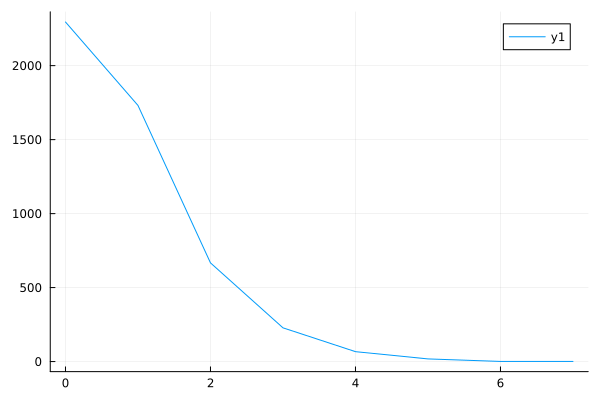

In [18]:
include("../../src/forces/forces.jl")

threads=(64,3)
@cuda(
    threads = threads,
    blocks = cld.(size(agg.Position,),threads),
    shmem=prod(threads.+2)*sizeof(Float32),
    sum_force!(
        agg.Position,
        agg.Simulation.Force.F,
        agg.Simulation.Force.Pol,
        agg.Simulation.Force.N_i,
        agg.Simulation.Neighbor.idx_sum,
        agg.Simulation.Neighbor.idx_red,
        agg.Simulation.Parameter.Force,
        agg.Simulation.Parameter.Contractile.fₚ,
        atan(1),
        pi/4,
        model.Time.dt
    )
)

# sum(agg.Simulation.Force.Pol.^2, dims=2)
# # display(sum(.!(0.0 .< agg.Simulation.Force.Pol .< 1.0),dims=1))

# # display(agg.Simulation.Force.F)
# # display(agg.Position)
# # display(agg.Position)

open("Pol.xyz", "w") do f
    write(f, "$(size(agg.Simulation.Force.Pol, 1))\n")
    write(f, "t=0\n")
    writedlm(f,hcat(agg.Geometry.outline,Matrix(agg.Simulation.Force.Pol)), ' ')
end

open("Force.xyz", "w") do f
    write(f, "$(size(agg.Simulation.Force.F, 1))\n")
    write(f, "t=0\n")
    writedlm(f,hcat(agg.Geometry.outline,Matrix(agg.Simulation.Force.F)), ' ')
end


using Plots

M = 0
FOMO = Matrix(agg.Simulation.Force.F)[:,1]
for i=unique(FOMO)
    if i == 0
        global M = [i sum(FOMO .== i)]
    else
        global M = vcat(M, [i sum(FOMO .== i)])
    end 
end

plot(M[:,1],M[:,2])

In [20]:
cos(0.15)

0.9887710779360422

In [19]:
M

8×2 Matrix{Float32}:
 0.0  2295.0
 1.0  1731.0
 2.0   667.0
 3.0   228.0
 4.0    67.0
 5.0    18.0
 6.0     1.0
 7.0     1.0